In [1]:
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import (Dense, Dropout, Embedding, BatchNormalization, 
                                     Flatten, SpatialDropout1D, LSTM, GRU, 
                                     Input, concatenate)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#%matplotlib inline

In [ ]:
path = '/datasets/'

In [3]:
# загружаем датасет и выводим первые 5 сторок
flats = pd.read_csv(path + '/moscow.csv', sep=';')
flats.head()

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."


In [4]:
# Удаляем строки 'для заметок' из столбца Комнат b и воccтанавливаем индексы
flats = flats[~flats['Комнат'].isin(['Для заметок:'])].reset_index(drop = True)
flats.sample(5)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
5360,1,Теплый стан м.,6п,8/9 П,NaN,NaN,33/19/7,7200000.0,NaN,NaN,25.07.2019,1.0,AVITO.ru,Продаётся отлична однокомнатная квартира в пят...
52179,1,NaN,NaN,15/25 П,NaN,С,35.7/10.1/17,5715570.0,NaN,NaN,24.07.2019,148.0,Прочие,ID в ИМЛС: 14831997 Группа ПИК. Новостройка! П...
87091,2,Селигерская м.,14т,15/22 М-К,Л,NaN,58.7/27.1/12.1,9717363.0,NaN,NaN,25.07.2019,21.0,Яндекс,Продажа квартиры напрямую от застройщика!\nПро...
60277,1,Ольховая м.,NaN,7/9 М,NaN,С,47.5/24.5/?,7200000.0,NaN,NaN,02.08.2019,9.0,Прочие,ID в ИМЛС: 14583776 Кожемякин Андрей. Комнаты ...
77585,2,Лесопарковая м.,4п,10/19 М,NaN,NaN,63.9/?/?,9483210.0,NaN,NaN,25.07.2019,8.0,AVITO.ru,Квартиры комфорт-класса в Москве от застройщик...


In [ ]:
# Выводим названия колонок
flats.columns.tolist()

['Комнат',
 'Метро / ЖД станции',
 'От станции',
 'Дом',
 'Балкон',
 'Санузел',
 'Площадь',
 'Цена, руб.',
 'ГРМ',
 'Бонус агенту',
 'Дата',
 'Кол-во дней в экспозиции',
 'Источник',
 'Примечание']

In [5]:
# Удаляем колонки которые не будут использоваться при создания Нейронной Сети
flats.drop(['ГРМ', 'Бонус агенту', 'Дата', 'Кол-во дней в экспозиции', 'Источник'], axis=1, inplace=True)
flats.head(3)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,Собственность оформлена! Ключи на руках! Опера...
1,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,Зеленоград к.1820 однокомнатная квартира общ.3...
2,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,"Уютная, светлая квартира, застекленный балкон ..."


In [ ]:
flat = 17 
for i in range(len(flats.values[flat])): 
  print(i, flats.columns[i], ':', flats.values[flat][i])

0 Комнат : 1
1 Метро / ЖД станции : Красногвардейская м.
2 От станции : 3п
3 Дом : 2/30 М
4 Балкон : -
5 Санузел : С
6 Площадь : 41.2/13.8/18.9
7 Цена, руб. : 7230600.0
8 Примечание : Чёрная Пятница. Суперскидки на лучшие квартиры от Донстрой! Новый корпус в продаже! ЖК "Фреш". Информация по телефону, наши менеджеры вам все расскажут! 1-комн. квартира в ЖК "FRESH" на 2 этаже. Общая площадь: 41.2 кв.м., жилая: 13.8 кв.м., площадь просторной кухни: 18.9 кв.м. В квартире один совмещенный санузел. Высота потолков 3.0 м. В квартире будут установлены панорамные стеклопакеты с повышенной тепло- и шумоизоляцией, заведены все коммуникации, установлены элементы отопления. Вы сможете реализовать самые смелые идеи в обустройстве своего нового дома. Старт продаж нового корпуса ЖК FRESH. Корпус расположен на границе парка долины реки Шмелевка. Из окон многих квартир открываются чудесные панорамы зеленого юга Москвы. В продаже представлены квартиры рациональных планировок, в том числе евроформаты с п

In [6]:
# данные из датасета в массив numpy
data = flats.values

In [ ]:
# Пример одного объявления из массива
data[17]

array(['1', 'Красногвардейская м.', '3п', '2/30 М', '-', 'С',
       '41.2/13.8/18.9', 7230600.0,
       'Чёрная Пятница. Суперскидки на лучшие квартиры от Донстрой! Новый корпус в продаже! ЖК "Фреш". Информация по телефону, наши менеджеры вам все расскажут! 1-комн. квартира в ЖК "FRESH" на 2 этаже. Общая площадь: 41.2 кв.м., жилая: 13.8 кв.м., площадь просторной кухни: 18.9 кв.м. В квартире один совмещенный санузел. Высота потолков 3.0 м. В квартире будут установлены панорамные стеклопакеты с повышенной тепло- и шумоизоляцией, заведены все коммуникации, установлены элементы отопления. Вы сможете реализовать самые смелые идеи в обустройстве своего нового дома. Старт продаж нового корпуса ЖК FRESH. Корпус расположен на границе парка долины реки Шмелевка. Из окон многих квартир открываются чудесные панорамы зеленого юга Москвы. В продаже представлены квартиры рациональных планировок, в том числе евроформаты с просторными кухнями-гостиными. Площади квартир: 24,3 м2 - 80,1 м2. ЖК FRESH- со

Готовим данные для Нейронной сети без Примечания

f - квартира

In [ ]:
# Выводим уникальные значения в столбце комнат
flats.Комнат.unique()

array(['1', nan, '2', '5', '6', '7', '8', '10', '9', '14', '13', '11',
       '15', '16', '12', '20', '30', '01.мар', '02.апр', '01.апр',
       '01.янв', '03.май', '01.фев', '02.мар', '01.июн', '01.авг',
       '03.апр', '01.май', '02.май', '01.сен', '01.июл', '02.июл',
       '03.июн', '05.июн', '03.авг', '01.окт', '04.май', '02.июн',
       '04.июн', '01.дек', '4', '03.июл', '02.фев', '03.мар', 'Ст'],
      dtype=object)

In [7]:
# Количество комнат
def get_rooms_count(f, max_rooms):
    rooms_str = f[0] # сторока с числом комнат

    rooms_count = 0
# создаем блок try-exept для предотвращения сбоя в работе при ошибке
    try:
        rooms_count = int(rooms_str)
        if rooms_count > max_rooms:
            rooms_count == max_rooms
    except:
        if rooms_str == rooms_str:
            if 'Ст' in rooms_str:
                rooms_count = max_rooms + 1

    return rooms_count

# Переводим количество комнат в категорию
def  get_rooms_count_to_categorical(f, max_rooms):
    rooms_count = get_rooms_count(f, max_rooms)
    rooms_count = utils.to_categorical(rooms_count, max_rooms + 2)

    return rooms_count

In [8]:
# Выводим уникальные значения в столбце Метро / ЖД станции
flats['Метро / ЖД станции'].unique()

array(['Шелепиха м.', 'Пятницкое шоссе м.', 'Планерная м.',
       'Шаболовская м.', 'Бабушкинская м.', 'Улица Дмитриевского м.',
       'Бульвар Рокоссовского м.', 'Марьина Роща м.', 'Марьино м.',
       'Печатники м.', 'Красногвардейская м.', 'Площадь Ильича м.',
       'Славянский бульвар м.', 'Раменки м.', 'Ботанический сад м.',
       'Маяковская м.', 'Хорошево м. (МЦК)', 'Проспект Вернадского м.',
       'Серпуховская м.', 'Улица Академика Янгеля м.', 'Крылатское м.',
       'Первомайская м.', 'Измайловская м.', 'Мичуринский проспект м.',
       'Бульвар Дмитрия Донского м.', 'Коптево м. (МЦК)',
       'Ростокино м. (МЦК)', 'Саларьево м.', 'Октябрьское поле м.',
       'Фрунзенская м.', 'Спортивная м.', 'Царицыно м.', 'Арбатская м.',
       'Юго-Западная м.', 'Белокаменная м. (МЦК)', 'Молодежная м.',
       'Медведково м.', 'Кунцевская м.', 'Авиамоторная м.',
       'Тимирязевская м.', 'Столбово м.', 'Селигерская м.', 'Коньково м.',
       'Бунинская аллея м.', 'Теплый стан м.',


In [9]:
# Наличие станция Метро и расстояние до неё
# станция метро
all_stations = ['Площадь Революции', 'Арбатская', 'Смоленская', 'Красные Ворота', 
            'Чистые Пруды', 'Лубянка', 'Охотный Ряд', 'Библиотека им. Ленина', 
            'Кропоткинская', 'Сухаревская', 'Тургеневская', 'Китай-Город', 
            'Третьяковская', 'Трубная', 'Сретенский Бульвар', 'Цветной Бульвар',
            'Чеховская', 'Боровицкая', 'Полянка', 'Маяковская', 'Тверская', 
            'Театральная', 'Новокузнецкая', 'Пушкинская', 'Кузнецкий Мост', 
            'Александровский Сад', 'Киевская', 'Парк Культуры', 'Октябрьская', 
            'Добрынинская', 'Павелецкая', 'Таганская', 'Курская', 'Комсомольская', 
            'Проспект Мира', 'Новослободская', 'Белорусская', 'Краснопресненская', 
            'Бауманская', 'Электрозаводская', 'Семёновская', 'Площадь Ильича', 
            'Авиамоторная', 'Шоссе Энтузиастов', 'Рижская', 'Крестьянская Застава', 
            'Дубровка', 'Пролетарская', 'Волгоградский Проспект', 'Текстильщики', 
            'Автозаводская', 'Технопарк', 'Коломенская', 'Тульская', 'Нагатинская', 
            'Нагорная', 'Шаболовская', 'Ленинский Проспект', 'Академическая', 
            'Фрунзенская', 'Спортивная', 'Воробьёвы Горы', 'Студенческая', 
            'Кутузовская', 'Фили', 'Парк Победы', 'Выставочная', 'Международная', 
            'Улица 1905 года', 'Беговая', 'Полежаевская', 'Динамо', 'Аэропорт', 
            'Сокол', 'Деловой Центр', 'Шелепиха', 'Хорошёвская', 'ЦСКА', 'Петровский Парк', 
            'Савёловская', 'Дмитровская', 'Тимирязевская', 'Достоевская', 'Марьина Роща', 
            'Бутырская', 'Фонвизинская', 'Римская', 'Алексеевская', 'ВДНХ', 
            'Красносельская', 'Сокольники', 'Преображенская Площадь', 'Партизанская', 
            'Измайловская', 'Первомайская', 'Щёлковская', 'Новокосино', 'Новогиреево', 
            'Перово', 'Кузьминки', 'Рязанский проспект', 'Выхино', 'Лермонтовский Проспект', 
            'Жулебино', 'Партизанская', 'Измайловская', 'Первомайская', 'Щёлковская', 
            'Новокосино', 'Новогиреево', 'Перово', 'Кузьминки', 'Улица Дмитриевского', 
            'Кожуховская', 'Печатники', 'Волжская', 'Люблино', 'Братиславская', 
            'Коломенская', 'Каширская', 'Кантемировская', 'Царицыно', 'Орехово', 
            'Севастопольская', 'Чертановская', 'Южная', 'Пражская', 'Варшавская', 
            'Профсоюзная', 'Новые Черёмушки', 'Калужская', 'Беляево', 'Коньково', 
            'Университет', 'Багратионовская', 'Филёвский Парк', 'Пионерская', 'Кунцевская', 
            'Молодёжная', 'Октябрьское Поле', 'Щукинская', 'Спартак', 'Тушинская', 
            'Сходненская', 'Войковская', 'Водный Стадион', 'Речной Вокзал', 
            'Беломорская', 'Ховрино', 'Петровско-Разумовская', 'Владыкино', 'Отрадное', 
            'Бибирево', 'Алтуфьево', 'Фонвизинская', 'Окружная', 'Верхние Лихоборы', 
            'Селигерская', 'Ботанический Сад', 'Свиблово', 'Бабушкинская', 'Медведково', 
            'Преображенская Площадь', 'Черкизовская', 'Бульвар Рокоссовского']

def get_metro(f, metro_stations):
    metro_str = f[1]
    metro = 0
    # Присваиваем индекс + 1, найденным станциям метро. 0-нет станции. 
    if metro_str in metro_stations:
        metro = metro_stations.index(metro_str) + 1
 
    return metro

# Создаем типы метро в зависимости от количества станций от кольца
def get_metro_type(f):
    metro_type_str = f[1]
    metro_type_classes = 5 # количество классов
    metro_type = metro_type_classes - 1
    
    # Распределяем по станциям
    metro_stations_inside_circle = all_stations[:26]
    metro_stations_one_circle = all_stations[26:38]
    metro_stations_two_circle = all_stations[38:92]
    metro_stations_three_circle = all_stations[92:]
    
    # распределяем по категориям
    if metro_type_str in metro_stations_inside_circle:
        metro_type = 0
    if metro_type_str in metro_stations_one_circle:
        metro_type = 1
    if metro_type_str in metro_stations_two_circle:
        metro_type = 2
    if metro_type_str in metro_stations_three_circle:
        metro_type = 3

    # В категорию
    metro_type = utils.to_categorical(metro_type, metro_type_classes)

    return metro_type

In [ ]:
# Выводим уникальные значения в столбце От станции
flats['От станции'].unique()

In [ ]:
# Расстояние до метро
def get_metro_distance(f):
    metro_distance_str = f[2]
    
    metro_distance = 0
    distance_type = 0

    if metro_distance_str == metro_distance_str:
        if len(metro_distance_str) > 0:
            if metro_distance_str[-1] =='п': 
                distance_type = 1                # пешком
            elif metro_distance_str[-1] == 'т':
                distance_type = 2                # транспортом

            # Выбираем толоко числа
            metro_distance_str[:-1]
    # создаем блок try-exept для предотвращения сбоя в работе при ошибке
            try:
    # разделяем дистаеции по категориям
                metro_distance = int(metro_distance_str)
                if metro_distance < 3:
                    metro_distance = 1
                if metro_distance < 6:
                    metro_distance = 2
                if metro_distance < 9:
                    metro_distance = 3
                if metro_distance < 12:
                    metro_distance = 4
                if metro_distance < 15:
                    metro_distance = 5
                if metro_distance < 20:
                    metro_distance = 6
                else: metro_distance = 7
            except:
                metro_distance = 0

    metro_distance_classes = 8

    # Преобразовываем индексы расстояний(тип_дистанции * дистанцию)
    if distance_type == 1:
        metro_distance = metro_distance                # пешком
    elif distance_type ==2:
        metro_distance += metro_distance_classes       # транспортом
    elif distance_type == 0:
        metro_distance += 2 * metro_distance_classes   # неизвестный тип

    # В категорию
    metro_distance = utils.to_categorical(metro_distance, metro_distance_classes * 3)

    return metro_distance

In [ ]:
# Выводим уникальные значения в столбце Дом
flats.Дом.unique()

array(['35/37 М', '11/14 П', '11/22 П', ..., '54/65 М', '3/53 М-К',
       '52/73 П'], dtype=object)

In [ ]:
# Дом. Этаж.
def get_hose_type_and_floor(f):
    try:
        house_str = f[3]
    except:
        hosuse_str = ''

    house_type = 0       # тип дома
    floor_flat = 0       # этаж квартиры
    floors_house = 0     # этажность дома
    is_last_floor = 0    # последний этаж

    if house_str == house_str:
        if len(house_str) > 1:
            try:
                slash_index = house_str.index('/')   # ищем разделитель
            except:
                print(house_str)
            try:
                space_index = house_str.index(' ')   # ищем разделитель
            except:
                print(house_str)

            # выбтаскиваем строки
            floor_flat_str = house_str[:slash_index]                   # этаж
            floors_house_str = house_str[slash_index +1:space_index]   # этажность дома
            house_type_str = house_str[space_index +1:]                # тип дома

            # Категории этажа
            try:
                floor_flat = int(floor_flat_str)
                floor_flat_save = floor_flat
                
                if floor_flat__save == 1:
                    floor_flat = 1
                if floor_flat_save < 5:
                    floor_flat = 2
                if floor_flat_save < 10:
                    floor_flat = 3
                if floor_flat_save < 20:
                    floor_flat = 4
                if floor_flat_save >= 20:
                    floor_flat = 5
                
                if floor_flat == floors_house:
                    is_last_floor = 1
            except:
                floor_flat = 0

            # Этажность дома
            try:
                floors_house = int(floors_house_str)
                floors_house_save = floors_house
                if floors_house_save < 5:
                    floors_house = 1
                if floors_house_save < 10:
                    floors_house = 2
                if floors_house_save < 20:
                    floors_house = 3
                if floors_house_save >= 20:
                    floors_house = 4
            except:
                floors_house = 0

            # Тип дома
            if len(house_type_str) > 0:
                if 'М' in house_type_str:
                    house_type = 1
                if 'К' in house_type_str:
                    house_type = 2
                if 'П' in house_type_str:
                    house_type = 3
                if 'Б' in house_type_str:
                    house_type = 4
                if '?' in house_type_str:
                    house_type = 5
                if '-' in house_type_str:
                    house_type = 6

        # Переводим все по этажам и дому в categorical
        floor_flat = utils.to_categorical(floor_flat, 6)
        floors_house = utils.to_categorical(floors_house, 5)
        house_type = utils.to_categorical(house_type, 7)

    return floor_flat, floors_house, is_last_floor, house_type

In [ ]:
# Выводим уникальные значения в столбце Балкон
flats.Балкон.unique()

array([nan, 'Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л',
       'ЭркЛ', '3Л', '4Л', '*Л', '*Б'], dtype=object)

In [ ]:
# Тип балкона
def get_balcony(f):
    balcony_str = f[4]
    # все варианты балконов в датасете
    balcony_variants =  ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
    # Проверяем на Nan выделяем 0 для Nan
    if balcony_str == balcony_str:
        balcony = balcony_variants.index(balcony_str) + 1
    else:
        balcony = 0

    # В categorical
    balcony = utils.to_categorical(balcony, 16)

    return balcony

In [ ]:
# Выводим уникальные значения в столбце Санузел
flats.Санузел.unique()

array(['2', 'Р', 'С', nan, '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4',
       '3', '3Р'], dtype=object)

In [ ]:
# Тип санузла
def get_wc(f):
    wc_str = f[5]
    wc_variants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']

    if wc_str == wc_str:
        wc = wc_variants.index(wc_str) + 1
    else:
         wc = 0

    # В categorical
    wc = utils.to_categorical(wc, 14)

    return wc

In [ ]:
# Выводим уникальные значения в столбце Площадь
flats.Площадь.unique()

array(['64.1/23/20', '38.4/17/9', '38.2/19.9/9.9', ..., '17.9/15.3/?',
       '26/10.9/?', '26/10.9/7'], dtype=object)

In [ ]:
# Площадь квартиры
def get_area(f):
    area_str = f[6]
    
    if ('/' in area_str):
        slash_index = area_str.index('/')
        try:
            area = float(area_str[:slash_index])
        except:
            area = 0   # не получается возврат 0
    else:
            area = 0   # нет разделителя возврат 0
    
    return area

In [ ]:
# Цена
def get_price(f):
    price_str = f[7]

    try:
        price = float(price_str)
    except:
        price = 0

    return price

In [ ]:
# Объединяем все числовые параметры
def get_numbers_parameters(f, metro_stations):
    # загружаем все по отдельности
    rooms_count_type = get_rooms_count_to_categorical(f, 30)
    metro = get_metro(f, metro_stations)
    metro_type = get_metro_type(f)
    metro_distance = get_metro_distance(f)
    floor_flat, floors_house, is_last_floor, house_type = get_hose_type_and_floor(f)
    balcony = get_balcony(f)
    wc = get_wc(f)
    area = get_area(f)

    # Объединяем в один лист
    out = list(rooms_count_type)
    out.append(metro)
    out.extend(metro_type)
    out.extend(metro_distance)
    out.extend(floor_flat)
    out.extend(floors_house)
    out.append(is_last_floor)
    out.extend(balcony)
    out.extend(wc)
    out.append(area)

    return out

In [ ]:
# Генерируем обучающую выборку X_train
def get_X_train(data):
    metro_stations = list(flats['Метро / ЖД станции'].unique()) #строка со всеми уникальными вариантами
    # Превращаем в векторы параметров и записываем в X_train
    X_train = [get_numbers_parameters(f, metro_stations) for f in data]
    X_train = np.array(X_train)

    return X_train

In [ ]:
# Генерируем обучающую выборку y_train
def get_y_train(data):
    # Загружаем все цены нв квартиры
    price_list = [get_price(f) for f in data]
    y_train = np.array(price_list)

    return y_train

In [ ]:
# Формируем обучающую выборку
X_train = get_X_train(data)
y_train = get_y_train(data)

In [ ]:
X_train.shape, y_train.shape

((126268, 105), (126268,))

In [ ]:
# Пример
print(X_train[1])
print(y_train[1])

[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   2.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  38.4]
4800000.0


In [ ]:
# Стандартизируем данные X
X_scaler = StandardScaler()
# пердаем двумерный вектор
X_scaler.fit(X_train.reshape(-1, 1))   
# нормализация по нормальному распределению
X_train_scaled = X_scaler.transform(X_train.reshape(-1, 1)).flatten()  

# Пример
print(X_train_scaled.shape)
print(X_train[5])
print(X_train_scaled[5])

(13258140,)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 44.]
-0.10621547823476808


In [ ]:
# Нормируем выходные даные - Цену
y_scaler = StandardScaler()
y_scaler.fit(y_train.reshape(-1, 1))
y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))

print(y_train_scaled.shape)
print(y_train[5])
print(y_train_scaled[5])

(126268, 1)
12700000.0
[-0.153471]


In [ ]:
# максимальные и минимальные значения после нормализации
print(f'Минимальное: {min(X_train_scaled)} \nМаксимальное: {max(X_train_scaled)}')

Минимальное: -0.10621547823476808 
Максимальное: 172.18674774400884


Готовим текстовые данные для Нейронной сети. Примечания.

In [ ]:
# Коментарии
def get_X_train_notes(values):
    X_train_notes = []

    for v in values:
        curr_note = ''
        if type(v[-1]) != float:
            curr_note += v[-1]
            
        
        X_train_notes.append(curr_note)

    X_train_notes = np.array(X_train_notes)

    return X_train_notes

In [ ]:
# Вытаскиваем примечания из flats
X_train_notes = get_X_train_notes(flats.values)

In [ ]:
# Пример примечания
X_train_notes[17]

'Чёрная Пятница. Суперскидки на лучшие квартиры от Донстрой! Новый корпус в продаже! ЖК "Фреш". Информация по телефону, наши менеджеры вам все расскажут! 1-комн. квартира в ЖК "FRESH" на 2 этаже. Общая площадь: 41.2 кв.м., жилая: 13.8 кв.м., площадь просторной кухни: 18.9 кв.м. В квартире один совмещенный санузел. Высота потолков 3.0 м. В квартире будут установлены панорамные стеклопакеты с повышенной тепло- и шумоизоляцией, заведены все коммуникации, установлены элементы отопления. Вы сможете реализовать самые смелые идеи в обустройстве своего нового дома. Старт продаж нового корпуса ЖК FRESH. Корпус расположен на границе парка долины реки Шмелевка. Из окон многих квартир открываются чудесные панорамы зеленого юга Москвы. В продаже представлены квартиры рациональных планировок, в том числе евроформаты с просторными кухнями-гостиными. Площади квартир: 24,3 м2 - 80,1 м2. ЖК FRESH- современный проект комфорт-класса в 3 мин. от м. "Красногвардейская". Дом монолитный, одноподъездный, высот

In [ ]:
X_train_notes.shape

(126268,)

In [ ]:
# Преобразовывает текстовые данные в числовые,векторные
max_words_count = 1000

tokenizer = Tokenizer(num_words=max_words_count, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(X_train_notes)
#items = list(tokenizer.word_index.items())

In [ ]:
# Преобразовываем в последовательность индексов
X_train_notes_indexes = tokenizer.texts_to_sequences(X_train_notes)

In [ ]:
# Создаем обучающую и проверочную выборку. Из индексов в последовательность 0 1. BOW.
X_train_notes_bow = tokenizer.sequences_to_matrix(X_train_notes_indexes)
y_train_notes_bow = tokenizer.sequences_to_matrix(X_train_notes_indexes)
X_train_notes_bow.shape

(126268, 1000)

In [ ]:
# Стандартизируем данные X_t
X_scaler_t = StandardScaler()
# пердаем двумерный вектор
X_scaler_t.fit(X_train_notes_bow)   
# нормализация по нормальному распределению
X_train_scaled_t = X_scaler_t.transform(X_train_notes_bow)

# Пример
print(X_train_scaled_t.shape)
print(X_train_notes_bow[5])
print(X_train_scaled_t[5])

(126268, 1000)
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
# Стандартизируем данные y_t
y_scaler_t = StandardScaler()
# пердаем двумерный вектор
y_scaler_t.fit(y_train_notes_bow)   
# нормализация по нормальному распределению
y_train_scaled_t = y_scaler_t.transform(y_train_notes_bow)

# Пример
print(y_train_scaled_t.shape)
print(y_train_notes_bow[5])
print(y_train_scaled_t[5])

(126268, 1000)
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Нейронка на числовых данных

In [ ]:
# Нейронка на числовых данных
model_d = Sequential([
                    #BatchNormalization(input_shape=(X_train.shape[1],)),
                    Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
                    Dense(100, activation='relu'), #'tanh'
                    Dense(10, activation='relu'),
                    #Dense(128, activation='relu'),
                    Dense(1, activation='linear')
                    ])

In [ ]:
model_d.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
callback = [ModelCheckpoint('/content/drive/MyDrive/UAI/Data_CSV/flats_d.hdf5', monitor='val_mae', save_best_only=True)]

In [ ]:
history_d = model_d.fit(X_train, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, callbacks=callback, verbose=1)

Epoch 1/50
3157/3157 [==============================] - 12s 4ms/step - loss: 0.1182 - mae: 0.1249 - val_loss: 3.8223 - val_mae: 0.7862
Epoch 2/50
3157/3157 [==============================] - 11s 3ms/step - loss: 0.0357 - mae: 0.0728 - val_loss: 1.8802 - val_mae: 0.5719
Epoch 3/50
3157/3157 [==============================] - 11s 3ms/step - loss: 0.0178 - mae: 0.0520 - val_loss: 2.7196 - val_mae: 0.7415
Epoch 4/50
3157/3157 [==============================] - 11s 3ms/step - loss: 0.0172 - mae: 0.0471 - val_loss: 1.6615 - val_mae: 0.5321
Epoch 5/50
3157/3157 [==============================] - 11s 4ms/step - loss: 0.0317 - mae: 0.0585 - val_loss: 1.6221 - val_mae: 0.5002
Epoch 6/50
3157/3157 [==============================] - 11s 3ms/step - loss: 0.0133 - mae: 0.0474 - val_loss: 3.6387 - val_mae: 0.8156
Epoch 7/50
3157/3157 [==============================] - 11s 3ms/step - loss: 0.0338 - mae: 0.0706 - val_loss: 6.0683 - val_mae: 1.0964
Epoch 8/50
3157/3157 [==============================] -

In [ ]:
mse, mae = model_d.evaluate(X_train[63134:], y_train[63134:])
print(mse,'//', mae)

1973/1973 [==============================] - 5s 3ms/step - loss: 13231488568918016.0000 - mae: 40359772.0000
1.3231488568918016e+16 // 40359772.0


In [ ]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Минимальная MAE на обучающей выборке: {min(history_d.history["mae"])} \
\nМинимальная MSE на обучающей выборе: {min(history_d.history["loss"])} \
\nМинимальная MAE на проверочной выборке: {min(history_d.history["val_mae"])} \
\nМинимальная MSE на проверочной выборе: {min(history_d.history["val_loss"])}')

Минимальная MAE на обучающей выборке: 0.047675322741270065 
Минимальная MSE на обучающей выборе: 0.019249331206083298 
Минимальная MAE на проверочной выборке: 0.4913639426231384 
Минимальная MSE на проверочной выборе: 1.5742357969284058


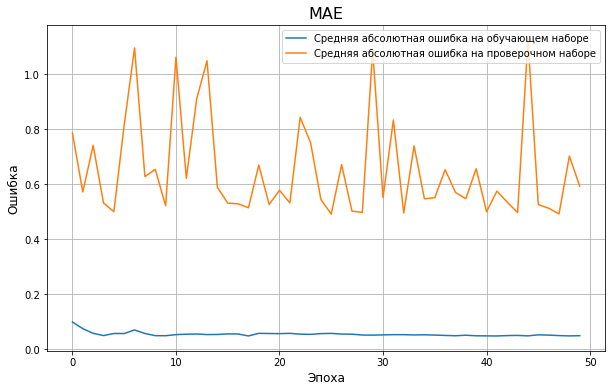

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_d.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history_d.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка',fontsize=12)
plt.legend()
plt.grid()
plt.title('MAE', fontsize=16)

plt.show()

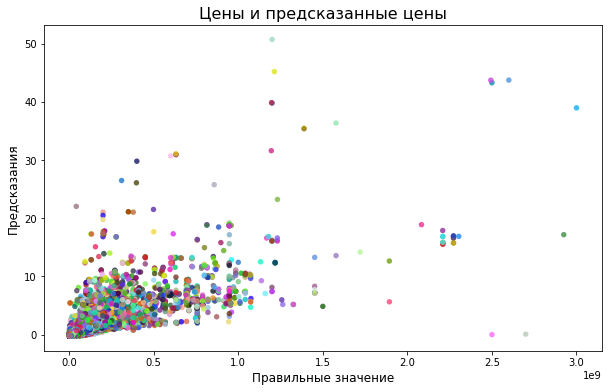

In [ ]:
price = y_train[63134:]
pred = model_d.predict(X_train[63134:]) 

fig = plt.figure(figsize=(10, 6))
groups= ('price', 'prediction')
colors = np.random.rand(63134, 3)
ax = fig.add_subplot(1, 1, 1,) 
ax.scatter(price, pred, alpha=0.8, c=colors, edgecolors='none', s=30)
plt.title('Цены и предсказанные цены', fontsize=16)
plt.xlabel('Правильные значение', fontsize=12)
plt.ylabel('Предсказания', fontsize=12)

plt.show()

In [ ]:
# Средняя цена квартиры по базе
print(f'Mean Prise in data: {flats.iloc[:,7].astype(float).mean():.4f}')

Mean Prise in data: 24876696.1181


In [ ]:
# Средняя ошибка
prediction = model_d.predict(X_train) 

prediction_unscaled = y_scaler.inverse_transform(prediction).flatten()

delta = prediction_unscaled - y_train
abs_delta = abs(delta)
mep_dig = (sum(abs_delta) / (0xf4240 * len(abs_delta)))
print('Средняя ошибка Цены: ', '%.4f' % mep_dig)

Средняя ошибка Цены:  12.2225


Нейронка на текстовых данных

In [ ]:
# Нейронка на текстовых данных
model_t = Sequential([
                     Dense(32, activation='relu', input_dim=(X_train_notes_bow.shape[1])),
                     Dense(128, activation='relu'),
                     Dense(16, activation='relu'),
                     Dense(1, activation='linear')
                   ])

In [ ]:
model_t.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])

In [ ]:
callback = [ModelCheckpoint('/content/drive/MyDrive/UAI/Data_CSV/flats_t.hdf5', monitor='val_mae', save_best_only=True)]

In [ ]:
history_t = model_t.fit(X_train_notes_bow[:63134], y_train_notes_bow[:63134], batch_size=32, epochs=50,
                        validation_data=(X_train_notes_bow[63134:], y_train_notes_bow[63134:]),
                         callbacks=callback,verbose=1, shuffle=True)

Epoch 1/50
1973/1973 [==============================] - 11s 6ms/step - loss: 0.0600 - mae: 0.1198 - val_loss: 0.0558 - val_mae: 0.1129
Epoch 2/50
1973/1973 [==============================] - 10s 5ms/step - loss: 0.0597 - mae: 0.1193 - val_loss: 0.0558 - val_mae: 0.1106
Epoch 3/50
1973/1973 [==============================] - 10s 5ms/step - loss: 0.0597 - mae: 0.1193 - val_loss: 0.0558 - val_mae: 0.1117
Epoch 4/50
1973/1973 [==============================] - 10s 5ms/step - loss: 0.0597 - mae: 0.1193 - val_loss: 0.0558 - val_mae: 0.1119
Epoch 5/50
1973/1973 [==============================] - 10s 5ms/step - loss: 0.0597 - mae: 0.1194 - val_loss: 0.0558 - val_mae: 0.1115
Epoch 6/50
1973/1973 [==============================] - 10s 5ms/step - loss: 0.0596 - mae: 0.1191 - val_loss: 0.0558 - val_mae: 0.1118
Epoch 7/50
1973/1973 [==============================] - 10s 5ms/step - loss: 0.0595 - mae: 0.1190 - val_loss: 0.0558 - val_mae: 0.1119
Epoch 8/50
1973/1973 [==============================] -

In [ ]:
mse, mae = model_t.evaluate(X_train_notes_bow[63134:], y_train_notes_bow[63134:])
print(mse,'//', mae)

In [ ]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Минимальная MAE на обучающей выборке: {min(history_t.history["mae"])} \
\nМинимальная MSE на обучающей выборе: {min(history_t.history["loss"])} \
\nМинимальная MAE на проверочной выборке: {min(history_t.history["val_mae"])} \
\nМинимальная MSE на проверочной выборе: {min(history_t.history["val_loss"])}')

Минимальная MAE на обучающей выборке: 0.11920162290334702 
Минимальная MSE на обучающей выборе: 0.059600554406642914 
Минимальная MAE на проверочной выборке: 0.11055641621351242 
Минимальная MSE на проверочной выборе: 0.055794607847929


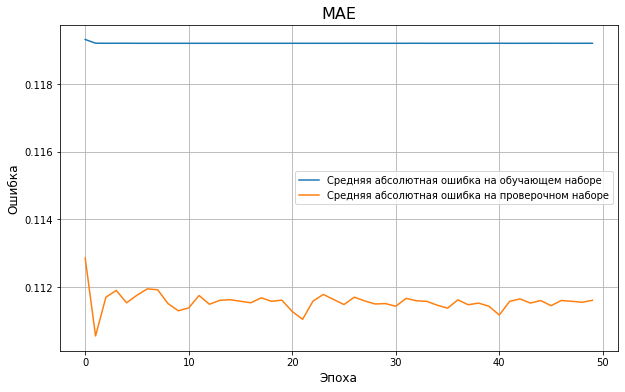

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_t.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history_t.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка',fontsize=12)
plt.legend()
plt.grid()
plt.title('MAE', fontsize=16)

plt.show()

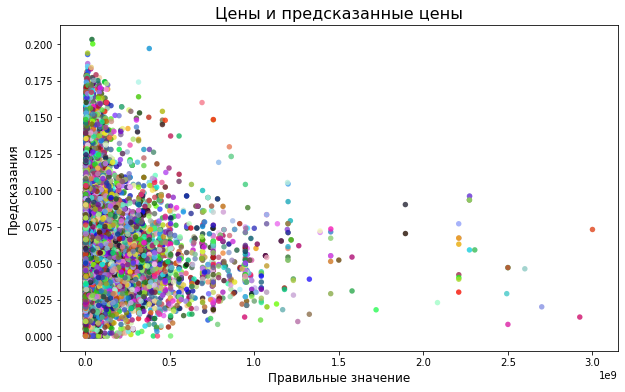

In [ ]:
price = y_train[63134:] # price
pred = model_t.predict(X_train_notes_bow[63134:]) # predict price

fig = plt.figure(figsize=(10, 6))
groups= ('price', 'prediction')
colors = np.random.rand(63134, 3)
ax = fig.add_subplot(1, 1, 1,) 
ax.scatter(price, pred, alpha=0.8, c=colors, edgecolors='none', s=30)
plt.title('Цены и предсказанные цены', fontsize=16)
plt.xlabel('Правильные значение', fontsize=12)
plt.ylabel('Предсказания', fontsize=12)

plt.show()

In [ ]:
# Средняя цена квартиры по базе
print(f'Mean Prise in data: {flats.iloc[:,7].astype(float).mean():.4f}')

Mean Prise in data: 24876696.1181


In [ ]:
# Предсказание в нормальном виде
prediction = model_t.predict(X_train_notes_bow)
prediction_unscaled = y_scaler.inverse_transform(prediction).flatten()
delta = prediction_unscaled - y_train
abs_delta = abs(delta)
mep_text = (sum(abs_delta) / (0xf4240 * len(abs_delta)))

print('Средняя ошибка Цены: ', '%.4f' % mep_text)

Средняя ошибка Цены:  31.4958


Составная нейронка

In [ ]:
input1 = Input((X_train.shape[1],))
d1 = BatchNormalization()(input1)
d1 = Dropout(0.5)(d1)
d1 = Dense(20, activation='relu',)(input1)
d1 = Dense(100, activation='relu')(d1)
d1 = Dense(10, activation='relu')(d1)


input2 = Input((X_train_notes_bow.shape[1],))
#t1 = BatchNormalization()(input2)
t1 = Dense(32, activation='relu')(input2)
t1 = Dense(644, activation='relu')(t1)
#t1 = Dense(64, activation='relu')(t1)
t1 = Dense(16, activation='relu')(t1)


c = concatenate([d1, t1])
c = Dense(16, activation='relu')(c)
c = Dropout(0.5)(c)
#c = Dense(64, activation='relu')(c)
c = Dense(32, activation='relu')(c)
#c = Flatten()(c)
c = Dense (1, activation='relu')(c)

In [ ]:
model = Model((input1, input2),c)

model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])

In [ ]:
callback = [ModelCheckpoint('/content/drive/MyDrive/UAI/Data_CSV/flats_all.hdf5', monitor='val_mae', save_best_only=True)]

In [ ]:
history = model.fit([X_train[:63134], X_train_notes_bow[:63134]], y_train[:63134], batch_size=32,
                    epochs=50, validation_data=([X_train[63134:], X_train_notes_bow[63134:]], y_train[63134:]),
                    callbacks=callback, verbose=1, shuffle=True)

Epoch 1/50
1973/1973 [==============================] - 14s 7ms/step - loss: 275569268465539.5000 - mae: 5961872.2908 - val_loss: 11077820168011776.0000 - val_mae: 29512378.0000
Epoch 2/50
1973/1973 [==============================] - 13s 7ms/step - loss: 224721096199266.5625 - mae: 3585591.1101 - val_loss: 9839131198750720.0000 - val_mae: 26095902.0000
Epoch 3/50
1973/1973 [==============================] - 13s 7ms/step - loss: 259289916708895.1250 - mae: 3113004.4616 - val_loss: 8363499621187584.0000 - val_mae: 22815352.0000
Epoch 4/50
1973/1973 [==============================] - 13s 7ms/step - loss: 210738511516365.9375 - mae: 3134234.5838 - val_loss: 7436265574105088.0000 - val_mae: 21479546.0000
Epoch 5/50
1973/1973 [==============================] - 13s 7ms/step - loss: 342495450018020.2500 - mae: 3416929.8159 - val_loss: 6748531251478528.0000 - val_mae: 20575298.0000
Epoch 6/50
1973/1973 [==============================] - 13s 7ms/step - loss: 233566431830870.8750 - mae: 3341684.2

In [ ]:
mse, mae = model.evaluate([X_train[63134:], X_train_notes_bow[63134:]], y_train[63134:], verbose=1)

print(mse,'//', mae)

1973/1973 [==============================] - 5s 3ms/step - loss: 6272224210190336.0000 - mae: 18848780.0000
6272224210190336.0 // 18848780.0


In [ ]:
# Минимальные ошибки на обучающей и проверочной выборе
print(f'Минимальная MAE на обучающей выборке: {min(history.history["mae"])} \
\nМинимальная MSE на обучающей выборе: {min(history.history["loss"])} \
\nМинимальная MAE на проверочной выборке: {min(history.history["val_mae"])} \
\nМинимальная MSE на проверочной выборе: {min(history.history["val_loss"])}')

Минимальная MAE на обучающей выборке: 2404157.0 
Минимальная MSE на обучающей выборе: 21409984151552.0 
Минимальная MAE на проверочной выборке: 18002208.0 
Минимальная MSE на проверочной выборе: 4278135050731520.0


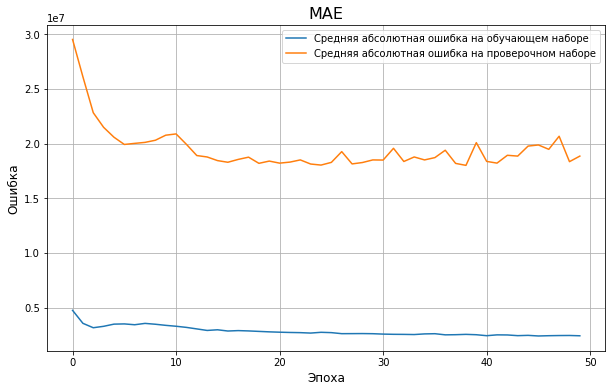

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка',fontsize=12)
plt.legend()
plt.grid()
plt.title('MAE', fontsize=16)

plt.show()

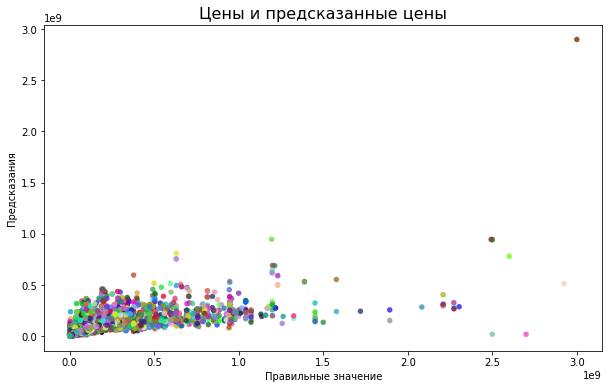

In [ ]:
price = y_train[63134:] # price
pred = model.predict([X_train[63134:], X_train_notes_bow[63134:]]) # predict price

fig = plt.figure(figsize=(10, 6))
data = (price, pred)
groups= ('price', 'prediction')
colors = np.random.rand(63134, 3)
ax = fig.add_subplot(1, 1, 1,) 
ax.scatter(x, y, alpha=0.8, c=colors, edgecolors='none', s=30)
plt.title('Цены и предсказанные цены', fontsize=16)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')

plt.show()

In [ ]:
# Средняя цена квартиры по базе
print(f'Mean Prise in data: {flats.iloc[:,7].astype(float).mean():.4f}')

Mean Prise in data: 24876696.1181


In [ ]:
# Средняя ошибка Цены
prediction = model.predict([X_train[:63134], X_train_notes_bow[:63134]])
prediction_unscaled = y_scaler.inverse_transform(prediction).flatten()
y_train_unscaled = y_scaler.inverse_transform(y_train_scaled[:63134]).flatten()
delta = prediction_unscaled - y_train_unscaled
abs_delta = abs(delta)
mep_concat = (sum(abs_delta) / (0xf4240 * len(abs_delta)) / 0x989680)
print('Средняя ошибка цены: ', '%.4f'%mep_concat) 

Средняя ошибка цены:  63.2339


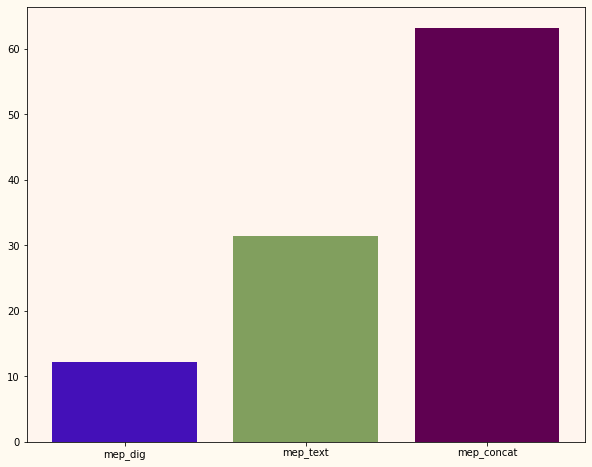

In [ ]:
# График сравнения Рейронных сетей
x = ('mep_dig', 'mep_text', 'mep_concat')
y = (mep_dig, mep_text, mep_concat)

fig, ax = plt.subplots()
color = np.random.rand(7, 3)
ax.bar(x, y, color=color)
fig.set_figwidth(10)
fig.set_figheight(8)
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

Датасет для предсказаний цен на квартиры в Москве. Имеем часть не нужных для создания нейронной сети столбцов. которые удалям. Приводим все данные в числовой вид. В том числе и колонку 'Примечание'. Создаем поочереди НС для числовых,  НС для текстовых и совместную НС. Обучаем Нейронные сети с сохранением лучших результатам по эпохам. Смотрим на показатели сетей. Большое увеличение слоев и нейронов ухудшает показатели. Лучшие показатели показывает: цифровая модель средняя ошибка в цене=12.2225. При работе с данным датасетом имеет смысл работать только с числовыми данными и доводить их до высоких показателей.

In [ ]:
hex(10000000)

'0x989680'